In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, box
import geopandas as gpd
import os, scipy
import warnings
warnings.filterwarnings('ignore')

# load data

In [3]:
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

In [4]:
# Defa + Obs sensitivity
df_defa = []
for i in range(len(df_info)):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/Defa/level1_{i}/Q_sensitivity_nocalib.csv'
    dfi = pd.read_csv(filei)
    dfi['basin'] = i
    df_defa.append(dfi)

df_defa = pd.concat(df_defa)

In [8]:
# Optmz + Obs sensitivity
df_optm = []
for i in range(len(df_info)):
    dfb = []
    for r in range(1, 6):
        filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_{i}/normKGEr{r}/Q_sensitivity_nocalib.csv'
        if os.path.isfile(filei):
            dfi = pd.read_csv(filei)
        else:
            dfi = dfi.copy()
            dfi['Obs']=np.nan
            dfi['Simu']=np.nan
            print('Missing:', filei)
        dfi['basin'] = i
        dfi['param'] = f'normKGEr{r}'
        dfb.append(dfi)

    dfb = pd.concat(dfb)
    df_optm.append(dfb)

df_optm = pd.concat(df_optm)

Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_13/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_119/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr1/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr2/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr3/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_464/normKGEr2/Q_sensitivity_nocalib.csv
Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_563/normKGEr3/Q_sensitivity_nocalib.csv


# test diff

In [25]:
s1 = []

for r in range(1, 6):
    dr = df_optm[ (df_optm['param']==f'normKGEr{r}') & (df_optm['senst']=='T') ]['Simu'].values
    s1.append(dr)

s1 = np.array(s1).T


In [26]:
print(np.nanmean(s1,axis=0))
print(np.nanmedian(s1,axis=0))
print(np.nanstd(s1,axis=0))


[-1.04935099 -1.40136338 -1.24444118 -1.18831739 -1.38283156]
[0.20702657 0.20424721 0.28870332 0.25251439 0.22791923]
[10.71045847 11.9380697  11.15893999 11.02546842 12.22779801]


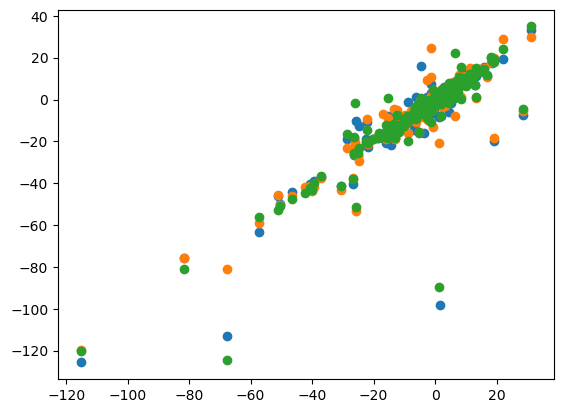

In [27]:
plt.scatter(s1[:,0], s1[:,1])
plt.scatter(s1[:,0], s1[:,2])
plt.scatter(s1[:,0], s1[:,4])